# Combinatorial Generalization with Homomorphism Autoencoders

The project aim to test several degree of combinatorial generalization capabilities a generative model is expected to exhibit.

Specifically, from the study PAPER_NAME by Montero et al., after a first elicitation of the combinatorial generalization problem, three types of combinatorial testing have been designed in an increasing difficulty fashion.

1. Example of Recombination-to-Element \\
    ```[shape = ellipse, scale = 1, orientation < 120◦, position-x > 0.5, position-y > 0.5]``` 
2. Example of Recombination-to-Range \\
    ```[shape = square, position-x > 0.5```
3. Example of Extrapolation \\
    ```[position-x > 0.5]```

Lately Keurti et al. proposed a multi-step autoencoder that aims to solve the combinatorial generation issue by enforcing the knwoledge that the encoder learns by exploiting the information given by the transformation action between k different images. Practically, instead of simply learning to generate a sample that exhibit a combination G of generative features, the model learns to encode the transformation from a first initial sample (generated using G_0 - set of generative figures) to a second one (G_1), and it continues like this for n ideal steps.

The goal of the project is to test the combinatorial testing types used by Montero et al. in the Homomorphism Autoencoder framework.

## Preliminary Imports

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Advanced_Machine_Learning

Mounted at /content/drive
/content/drive/MyDrive/Advanced_Machine_Learning


In [3]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 27.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.9 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=1e7605a99b8ea54cf65afd922df1ad2bca1e97d1cf551dd87810215cb05b1508
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


## DSprite

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import json

In [5]:
# Helper function to show images
def show_images_grid(imgs_, num_images=25):
    """
    """
    ncols = int(np.ceil(num_images**0.5))
    nrows = int(np.ceil(num_images / ncols))
    _, axes = plt.subplots(ncols, 
                           nrows, 
                           figsize=(nrows * 3, ncols * 3))
    axes = axes.flatten()

    for ax_i, ax in enumerate(axes):
        if ax_i < num_images:
            ax.imshow(imgs_[ax_i], 
                    cmap='Greys_r',  
                    interpolation='nearest')
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')

In [6]:
def show_density(imgs):
    """
    """
    _, ax = plt.subplots()
    ax.imshow(imgs.mean(axis=0), 
              interpolation='nearest', 
              cmap='Greys_r')
    ax.grid('off')
    ax.set_xticks([])
    ax.set_yticks([])

In [7]:
def load_dsprite():
    """
    """
    dataset_zip = np.load('/content/drive/MyDrive/Advanced_Machine_Learning/dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', 
                          allow_pickle=True, 
                          encoding='latin1')

    imgs = dataset_zip['imgs']
    latents_values = dataset_zip['latents_values']
    latents_classes = dataset_zip['latents_classes']
    metadata = dataset_zip['metadata'][()]

    return imgs, metadata

In [8]:
def exclude_from_training(imgs, metadata, shape=None, scale=None, orientation=None, posX=None, posY=None):
    """Extract the images given a specific set of latents value and operator.
    Example:

    >> exclude_from_training(imgs, metadata, shape="== 0", orientation="> 10")
    # Return all images of shape 0 and orientation > 10

    Latents order is ('color', 'shape', 'scale', 'orientation', 'posX', 'posY')
    Shape order is (square, ellipse, heart)
    """
    def _latent_to_index(latents, metadata):
        latents_sizes = metadata['latents_sizes']
        latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                        np.array([1,])))
        return np.dot(latents, latents_bases).astype(int)

    num_given_factors = bool(shape) \
                      + bool(scale) \
                      + bool(orientation) \
                      + bool(posX) \
                      + bool(posY)

    factors = [None, shape, scale, orientation, posX, posY]
    factors = [">= 0" if not f else f for f in factors]
    factors = [{"compare": f.split(" ")[0], "value": int(f.split(" ")[1])}
               for f in factors]

    if num_given_factors == 5:
        combination_type = "rec2element" 
    elif num_given_factors < 5 and num_given_factors >= 2:
        combination_type = "rec2range"
    elif num_given_factors == 1:
        combination_type = "extrap"
    else:
        raise ValueError("Invalid combination type")

    latents_2_sample = []

    # Color is fixed so first element is excluded
    for idx, factor_name in enumerate(metadata["latents_names"]): 

        if factors[idx]["compare"] == "<":
            latents_2_sample.append(list(range(0, factors[idx]["value"])))

        elif factors[idx]["compare"] == "<=":
            latents_2_sample.append(list(range(0, factors[idx]["value"]+1)))

        elif factors[idx]["compare"] == "==":
            latents_2_sample.append([factors[idx]["value"]])

        elif factors[idx]["compare"] == ">=":
            latents_2_sample.append(list(range(factors[idx]["value"], metadata["latents_sizes"][idx])))

        elif factors[idx]["compare"] == ">":
            latents_2_sample.append(list(range(factors[idx]["value"]+1, metadata["latents_sizes"][idx])))

        else:
            raise ValueError("Invalid comparison symbol")

    latents_sampled = np.asarray(list(itertools.product(*latents_2_sample)))

    # Select images
    indices_sampled = _latent_to_index(latents_sampled, metadata)
    indices_sampled = list(set(indices_sampled))
    imgs_sampled = imgs[indices_sampled]

    return imgs_sampled, indices_sampled, combination_type

In [9]:
imgs, metadata = load_dsprite()

In [10]:
metadata

{'date': 'April 2017',
 'description': 'Disentanglement test Sprites dataset.Procedurally generated 2D shapes, from 6 disentangled latent factors.This dataset uses 6 latents, controlling the color, shape, scale, rotation and position of a sprite. All possible variations of the latents are present. Ordering along dimension 1 is fixed and can be mapped back to the exact latent values that generated that image.We made sure that the pixel outputs are different. No noise added.',
 'version': 1,
 'latents_names': ('color', 'shape', 'scale', 'orientation', 'posX', 'posY'),
 'latents_possible_values': {'orientation': array([0.        , 0.16110732, 0.32221463, 0.48332195, 0.64442926,
         0.80553658, 0.96664389, 1.12775121, 1.28885852, 1.44996584,
         1.61107316, 1.77218047, 1.93328779, 2.0943951 , 2.25550242,
         2.41660973, 2.57771705, 2.73882436, 2.89993168, 3.061039  ,
         3.22214631, 3.38325363, 3.54436094, 3.70546826, 3.86657557,
         4.02768289, 4.1887902 , 4.34989

In [81]:
imgs_sampled, indices_sampled, combination_type = exclude_from_training(imgs, 
                                                                        metadata, 
                                                                        shape="== 2", 
                                                                        posX="== 0", 
                                                                        posY="== 0", 
                                                                        orientation="== 0", 
                                                                        scale="== 0")

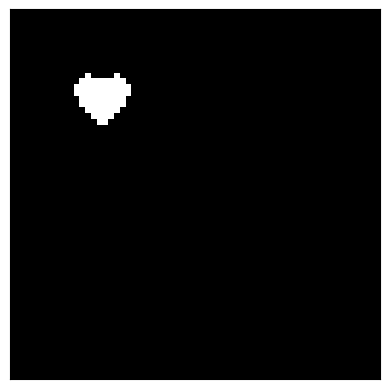

In [82]:
show_density(imgs_sampled)

In [83]:
imgs_sampled, indices_sampled, combination_type = exclude_from_training(imgs, 
                                                                        metadata, 
                                                                        shape="== 2", 
                                                                        posX=">= 15", 
                                                                        posY="== 0", 
                                                                        orientation="== 0", 
                                                                        scale="== 0")

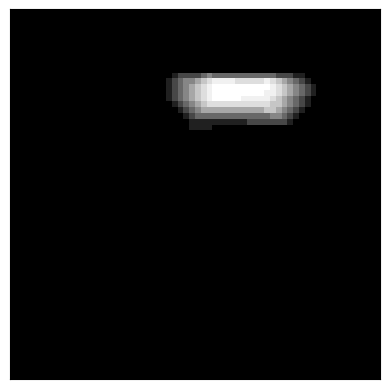

In [84]:
show_density(imgs_sampled)

In [85]:
imgs_sampled, indices_sampled, combination_type = exclude_from_training(imgs, 
                                                                        metadata, 
                                                                        shape="== 1",
                                                                        scale="== 5",
                                                                        orientation="== 14",
                                                                        posX="== 15",
                                                                        posY=">= 15")

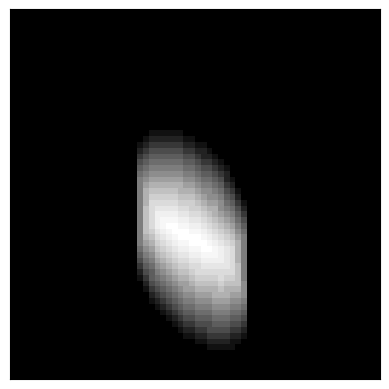

In [86]:
show_density(imgs_sampled)

In [87]:
name = "/content/drive/MyDrive/Advanced_Machine_Learning/remove_from_train_shape_equal_1__scale_equal_5__orientation_equal_14__posX_equal_15__posY_greater_equal_15.json"

In [88]:
with open(name, "w") as f:
    json.dump([int(i) for i in indices_sampled], f)

In [99]:
# Extrapolation
imgs_sampled, indices_sampled, combination_type = exclude_from_training(imgs, 
                                                                        metadata, 
                                                                        shape="== 1",
                                                                        posX=">= 15",
                                                                        posY=">= 15")

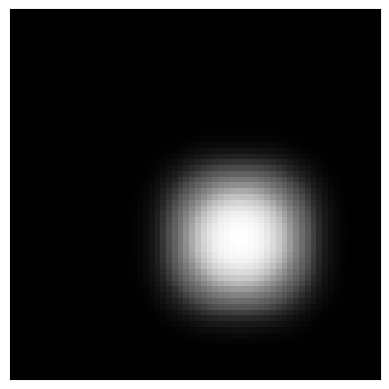

In [100]:
show_density(imgs_sampled)

In [101]:
name = "/content/drive/MyDrive/Advanced_Machine_Learning/remove_from_train_shape_equal_1___posX_greater_equal_15__posY_greater_equal_15.json"

In [102]:
with open(name, "w") as f:
    json.dump([int(i) for i in indices_sampled], f)

In [103]:
# Extrapolation
imgs_sampled, indices_sampled, combination_type = exclude_from_training(imgs, 
                                                                        metadata, 
                                                                        shape="== 1", 
                                                                        posX=">= 15")

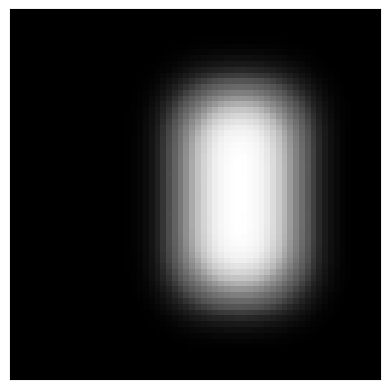

In [104]:
show_density(imgs_sampled)

In [105]:
name = "/content/drive/MyDrive/Advanced_Machine_Learning/remove_from_train_shape_equal_1__posX_greater_equal_15.json"

In [106]:
with open(name, "w") as f:
    json.dump([int(i) for i in indices_sampled], f)

## Run Homomorphismae in python

In [107]:
%load_ext autoreload
%autoreload 2
%cd /content/drive/MyDrive/Advanced_Machine_Learning/homomorphismvae/displacementae

from utils import misc
from torch.utils.data import DataLoader
from data.dsprites import DspritesDataset
import homomorphism.train_args as train_args
import homomorphism.train_utils as tutils
from grouprepr.representation_utils import Representation
from argparse import Namespace
from contextlib import ExitStack
import wandb
import copy
import utils.sim_utils as sim_utils
import data.data_utils as data_utils
import networks.network_utils as net_utils
from datetime import datetime
import argparse
from datetime import datetime
import torch
import utils.args as args
from grouprepr.representation_utils import Representation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/content/drive/MyDrive/Advanced_Machine_Learning/homomorphismvae/displacementae


In [113]:
input_args = "--dataset=dsprites --data_root=/content/drive/MyDrive/Advanced_Machine_Learning/dsprites-dataset --cyclic_trans --fixed_in_intervention=0,1,2,3 --fixed_in_sampling=0,1,2,3 --fixed_values=0,1,5,14 --distrib=uniform --displacement_range=-10,10 --n_steps=2 --rotate_actions=45 --num_train=10000 --batch_size=500 --epochs=101 --log_wandb --lr=0.001 --toggle_training_every=2,2 --shuffle=1 --use_adam --use_cuda --conv_channels=64,64,64,64 --kernel_sizes=6,4,4,4 --strides=2,2,1,1 --lin_channels=1024 --net_act=relu --dims=2,2 --group_hidden_units=128,128 --reconstruct_first --exponential_map --latent_loss --latent_loss_weight=400 --val_epoch=10 --num_val=500 --plot_epoch=10 --plot_manifold_latent=[0,1] --plot_manifold --plot_reconstruction --plot_pca --plot_vary_latents=[4,5]".split(" ")
# input_args = "--combinatorial_indices=/content/drive/MyDrive/Advanced_Machine_Learning/remove_from_train_shape_equal_1__posX_greater_equal_15.json --dataset=dsprites --data_root=/content/drive/MyDrive/Advanced_Machine_Learning/dsprites-dataset --cyclic_trans --fixed_in_intervention=0,1,2,3 --fixed_in_sampling=0,1,2,3 --fixed_values=0,1,5,14 --distrib=uniform --displacement_range=-10,10 --n_steps=2 --rotate_actions=45 --num_train=10000 --batch_size=500 --epochs=101 --log_wandb --lr=0.001 --toggle_training_every=2,2 --shuffle=1 --use_adam --use_cuda --conv_channels=64,64,64,64 --kernel_sizes=6,4,4,4 --strides=2,2,1,1 --lin_channels=1024 --net_act=relu --dims=2,2 --group_hidden_units=128,128 --reconstruct_first --exponential_map --latent_loss --latent_loss_weight=400 --val_epoch=10 --num_val=500 --plot_epoch=10 --plot_manifold_latent=[0,1] --plot_manifold --plot_reconstruction --plot_pca --plot_vary_latents=[4,5]".split(" ")
input_args # Test with ellipsis subset

['--dataset=dsprites',
 '--data_root=/content/drive/MyDrive/Advanced_Machine_Learning/dsprites-dataset',
 '--cyclic_trans',
 '--fixed_in_intervention=0,1,2,3',
 '--fixed_in_sampling=0,1,2,3',
 '--fixed_values=0,1,5,14',
 '--distrib=uniform',
 '--displacement_range=-10,10',
 '--n_steps=2',
 '--rotate_actions=45',
 '--num_train=10000',
 '--batch_size=500',
 '--epochs=101',
 '--log_wandb',
 '--lr=0.001',
 '--toggle_training_every=2,2',
 '--shuffle=1',
 '--use_adam',
 '--use_cuda',
 '--conv_channels=64,64,64,64',
 '--kernel_sizes=6,4,4,4',
 '--strides=2,2,1,1',
 '--lin_channels=1024',
 '--net_act=relu',
 '--dims=2,2',
 '--group_hidden_units=128,128',
 '--reconstruct_first',
 '--exponential_map',
 '--latent_loss',
 '--latent_loss_weight=400',
 '--val_epoch=10',
 '--num_val=500',
 '--plot_epoch=10',
 '--plot_manifold_latent=[0,1]',
 '--plot_manifold',
 '--plot_reconstruction',
 '--plot_pca',
 '--plot_vary_latents=[4,5]']

In [114]:
def setup_data(config, mode='homomorphism'):
    """
    """
    if config.dataset == 'dsprites':
        return setup_dsprites_dataset(config, mode)

def setup_dsprites_dataset(config, mode='homomorphism'):
    """
    """
    fixed_in_sampling = misc.str_to_ints(config.fixed_in_sampling)
    fixed_values = misc.str_to_ints(config.fixed_values)
    fixed_in_action = misc.str_to_ints(config.fixed_in_intervention)
    action_range = misc.str_to_ints(config.displacement_range)
    if mode == 'homomorphism':
        config.intervene = True
    dhandler = DspritesDataset(
        root=config.data_root,
        num_train=config.num_train,
        num_val=config.num_val,
        rseed=config.data_random_seed,
        fixed_in_sampling=fixed_in_sampling,
        fixed_values=fixed_values,
        fixed_in_action=fixed_in_action,
        transitions_on=config.intervene,
        n_transitions=config.n_steps,
        action_range=action_range,
        cyclic_trans=config.cyclic_trans,
        dist=config.distrib,
        return_integer_actions=config.integer_actions,
        rotate_actions=config.rotate_actions,
        combinatorial_indices_file=config.combinatorial_indices,
        )
    dloader = DataLoader(
        dataset=dhandler, batch_size=config.batch_size,
        shuffle=config.shuffle)
    return dhandler, dloader

In [115]:
def parse_cmd_arguments(representation=Representation.BLOCK_ROTS,
                        description='', argv=None):
    """
    """
    mode='homomorphism'
    curr_date = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    if not description:
        description = 'N Steps Autoencoder'
    dout_dir = './out/run_' + curr_date
    parser = argparse.ArgumentParser(description=description)
    args.data_args(parser,mode)
    args.train_args(parser)
    args.net_args(parser)
    args.misc_args(parser, dout_dir)
    args.group_repr_args(parser,representation)

    config = parser.parse_args(args=argv)

    config.intervene = True
    return config

In [116]:
representation = Representation.BLOCK_MLP
mode = "homomorphism"

config = train_args.parse_cmd_arguments(representation, argv=input_args)
device = torch.device("cuda")
device, logger = sim_utils.setup_environment(config)
sim_utils.backup_cli_command(config)

dhandler, dloader = setup_data(config, mode)
nets = net_utils.setup_network(config, dhandler, device, mode=mode,
                                   representation=representation)

shared = Namespace()
sim_utils.setup_summary_dict(config, shared, nets)

Created output folder ./out/run_2023-04-22_17-00-49.
04/22/2023 05:00:49 PM - INFO - Using cuda : True
04/22/2023 05:00:49 PM - INFO - Using cuda : True
04/22/2023 05:00:49 PM - INFO - Using cuda : True
04/22/2023 05:00:49 PM - INFO - Using cuda : True
04/22/2023 05:00:49 PM - INFO - Using cuda : True
04/22/2023 05:00:49 PM - INFO - Using cuda : True
04/22/2023 05:00:49 PM - INFO - Using cuda : True
04/22/2023 05:00:49 PM - INFO - Using cuda : True


INFO:logger:Using cuda : True


### Train images

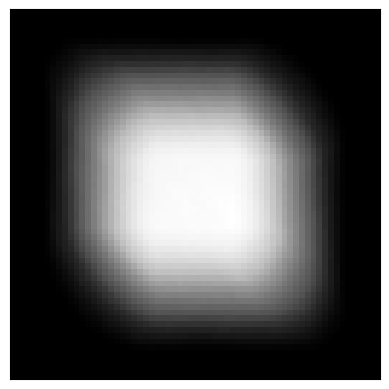

In [117]:
imgs, metadata = load_dsprite()

show_density(imgs[dhandler.all_indices[dhandler.train_idx.flatten()]])

In [118]:
new_train_idx = []

for k in range(copy.deepcopy(dhandler.train_idx.shape[0])):
    if not set(dhandler.all_indices[dhandler.train_idx[k]].tolist()).intersection(set(indices_sampled)):
        new_train_idx.append(dhandler.train_idx[k].tolist())

dhandler.train_idx = np.asarray(new_train_idx)

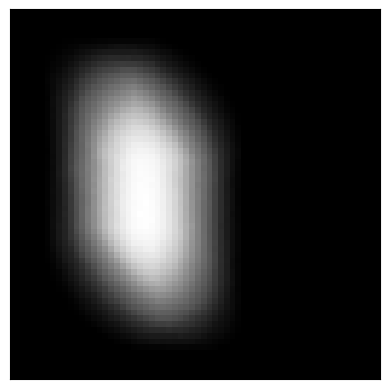

In [119]:
show_density(imgs[dhandler.all_indices[dhandler.train_idx.flatten()]])

### Validation images

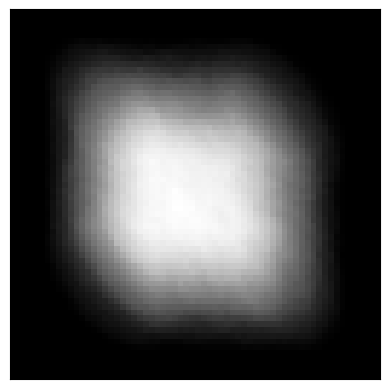

In [120]:
show_density(imgs[dhandler.all_indices[dhandler.val_idx.flatten()]])

In [121]:
new_val_idx = []

for k in range(copy.deepcopy(dhandler.val_idx.shape[0])):
    if set([dhandler.all_indices[dhandler.val_idx[k, 0]]]).intersection(set(indices_sampled)):
        new_val_idx.append(dhandler.val_idx[k].tolist())

dhandler.val_idx = np.asarray(new_val_idx)

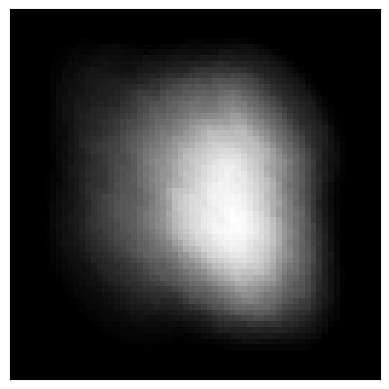

In [122]:
show_density(imgs[dhandler.all_indices[dhandler.val_idx.flatten()]])

## Homomorphism Autoencoder Ellipsis Dataset

In [ ]:
# WAND_API_KEY = "7bb6efe911fc751a25083e6f77d38c5900d85304"

### No Recombination

In [ ]:
%cd /content/drive/MyDrive/Advanced_Machine_Learning/homomorphismvae/displacementae/homomorphism/
!python3 train_block_mlp_repr.py --dataset=dsprites --data_root=/content/drive/MyDrive/Advanced_Machine_Learning/dsprites-dataset --cyclic_trans --fixed_in_intervention=0,1,2,3 --fixed_in_sampling=0,1,2,3 --fixed_values=0,1,5,14 --distrib=uniform --displacement_range=-10,10 --n_steps=2 --rotate_actions=45 --num_train=10000 --batch_size=500 --epochs=101 --log_wandb --lr=0.001 --toggle_training_every=2,2 --shuffle=1 --use_adam --use_cuda --conv_channels=64,64,64,64 --kernel_sizes=6,4,4,4 --strides=2,2,1,1 --lin_channels=1024 --net_act=relu --dims=2,2 --group_hidden_units=128,128 --reconstruct_first --exponential_map --latent_loss --latent_loss_weight=400 --val_epoch=10 --num_val=500 --plot_epoch=10 --plot_manifold_latent=[0,1] --plot_manifold --plot_reconstruction --plot_pca --plot_vary_latents=[4,5]

/content/drive/MyDrive/Advanced_Machine_Learning/homomorphismvae/displacementae/homomorphism
Created output folder ./out/run_2023-04-19_15-19-26.
04/19/2023 03:19:26 PM - INFO - Using cuda : True
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: 2
wandb: You chose 'Use an existing W&B account'
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Tracking run with wandb version 0.14.2
wandb: Run data is saved locally in /content/drive/MyDrive/Advanced_Machine_Learning/homomorphismvae/displacementae/homomorphism/wandb/run-20230419_151940-969ss2ye
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run exp

### Recombination to Element

In [80]:
%cd /content/drive/MyDrive/Advanced_Machine_Learning/homomorphismvae/displacementae/homomorphism/
!python3 train_block_mlp_repr.py --combinatorial_indices=/content/drive/MyDrive/Advanced_Machine_Learning/remove_from_train_shape_equal_1__scale_equal_5__orientation_equal_14__posX_equal_15__posY_greater_equal_15.json --dataset=dsprites --data_root=/content/drive/MyDrive/Advanced_Machine_Learning/dsprites-dataset --cyclic_trans --fixed_in_intervention=0,1,2,3 --fixed_in_sampling=0,1,2,3 --fixed_values=0,1,5,14 --distrib=uniform --displacement_range=-10,10 --n_steps=2 --rotate_actions=45 --num_train=10000 --batch_size=500 --epochs=101 --log_wandb --lr=0.001 --toggle_training_every=2,2 --shuffle=1 --use_adam --use_cuda --conv_channels=64,64,64,64 --kernel_sizes=6,4,4,4 --strides=2,2,1,1 --lin_channels=1024 --net_act=relu --dims=2,2 --group_hidden_units=128,128 --reconstruct_first_only --exponential_map --latent_loss --latent_loss_weight=400 --val_epoch=10 --num_val=500 --plot_epoch=10 --plot_manifold_latent=[0,1] --plot_manifold --plot_reconstruction --plot_pca --plot_vary_latents=[4,5]

/content/drive/MyDrive/Advanced_Machine_Learning/homomorphismvae/displacementae/homomorphism
Created output folder ./out/run_2023-04-22_16-28-30.
04/22/2023 04:28:30 PM - INFO - Using cuda : True
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: 2
wandb: You chose 'Use an existing W&B account'
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Tracking run with wandb version 0.15.0
wandb: Run data is saved locally in /content/drive/MyDrive/Advanced_Machine_Learning/homomorphismvae/displacementae/homomorphism/wandb/run-20230422_162838-3ey46wbr
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ski

### Recombination to range

In [124]:
%cd /content/drive/MyDrive/Advanced_Machine_Learning/homomorphismvae/displacementae/homomorphism/
!python3 train_block_mlp_repr.py --combinatorial_indices=/content/drive/MyDrive/Advanced_Machine_Learning/remove_from_train_shape_equal_1___posX_greater_equal_15__posY_greater_equal_15.json --dataset=dsprites --data_root=/content/drive/MyDrive/Advanced_Machine_Learning/dsprites-dataset --cyclic_trans --fixed_in_intervention=0,1,2,3 --fixed_in_sampling=0,1,2,3 --fixed_values=0,1,5,14 --distrib=uniform --displacement_range=-10,10 --n_steps=2 --rotate_actions=45 --num_train=10000 --batch_size=500 --epochs=101 --log_wandb --lr=0.001 --toggle_training_every=2,2 --shuffle=1 --use_adam --use_cuda --conv_channels=64,64,64,64 --kernel_sizes=6,4,4,4 --strides=2,2,1,1 --lin_channels=1024 --net_act=relu --dims=2,2 --group_hidden_units=128,128 --reconstruct_first_only --exponential_map --latent_loss --latent_loss_weight=400 --val_epoch=10 --num_val=500 --plot_epoch=10 --plot_manifold_latent=[0,1] --plot_manifold --plot_reconstruction --plot_pca --plot_vary_latents=[4,5]

/content/drive/MyDrive/Advanced_Machine_Learning/homomorphismvae/displacementae/homomorphism
Created output folder ./out/run_2023-04-22_17-05-56.
04/22/2023 05:05:56 PM - INFO - Using cuda : True
wandb: Currently logged in as: simonecaldarella. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.0
wandb: Run data is saved locally in /content/drive/MyDrive/Advanced_Machine_Learning/homomorphismvae/displacementae/homomorphism/wandb/run-20230422_170622-4you5i73
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run lively-bird-20
wandb: ⭐️ View project at https://wandb.ai/simonecaldarella/homomorphism-autoencoder
wandb: 🚀 View run at https://wandb.ai/simonecaldarella/homomorphism-autoencoder/runs/4you5i73
04/22/2023 05:06:22 PM - INFO - ### Training ###
04/22/2023 05:06:23 PM - INFO - EVALUATION prior to epoch [0]...
04/22/2023 05:06:23 PM - INFO - [0] loss	2897.66=	BCE 2897.66 	LL 0.00051 
04/22/2023 05:06:24 PM - INFO - Figure saved ./out

### Extrapolation

In [ ]:
%cd /content/drive/MyDrive/Advanced_Machine_Learning/homomorphismvae/displacementae/homomorphism/
!python3 train_block_mlp_repr.py --combinatorial_indices=/content/drive/MyDrive/Advanced_Machine_Learning/remove_from_train_shape_equal_1__posX_greater_equal_15.json --dataset=dsprites --data_root=/content/drive/MyDrive/Advanced_Machine_Learning/dsprites-dataset --cyclic_trans --fixed_in_intervention=0,1,2,3 --fixed_in_sampling=0,1,2,3 --fixed_values=0,1,5,14 --distrib=uniform --displacement_range=-10,10 --n_steps=2 --rotate_actions=45 --num_train=10000 --batch_size=500 --epochs=101 --log_wandb --lr=0.001 --toggle_training_every=2,2 --shuffle=1 --use_adam --use_cuda --conv_channels=64,64,64,64 --kernel_sizes=6,4,4,4 --strides=2,2,1,1 --lin_channels=1024 --net_act=relu --dims=2,2 --group_hidden_units=128,128 --reconstruct_first --exponential_map --latent_loss --latent_loss_weight=400 --val_epoch=10 --num_val=500 --plot_epoch=10 --plot_manifold_latent=[0,1] --plot_manifold --plot_reconstruction --plot_pca --plot_vary_latents=[4,5]

/content/drive/MyDrive/Advanced_Machine_Learning/homomorphismvae/displacementae/homomorphism
Created output folder ./out/run_2023-04-20_15-54-11.
04/20/2023 03:54:11 PM - INFO - Using cuda : True
wandb: Currently logged in as: simonecaldarella. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.0
wandb: Run data is saved locally in /content/drive/MyDrive/Advanced_Machine_Learning/homomorphismvae/displacementae/homomorphism/wandb/run-20230420_155441-27unq9li
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ancient-frog-15
wandb: ⭐️ View project at https://wandb.ai/simonecaldarella/homomorphism-autoencoder
wandb: 🚀 View run at https://wandb.ai/simonecaldarella/homomorphism-autoencoder/runs/27unq9li
04/20/2023 03:54:43 PM - INFO - ### Training ###
04/20/2023 03:54:43 PM - INFO - EVALUATION prior to epoch [0]...
04/20/2023 03:54:43 PM - INFO - [0] loss	2897.61=	BCE 2897.61 	LL 0.00049 
04/20/2023 03:54:45 PM - INFO - Figure saved ./ou

### Results

No Combinatorial Generalization 

```
wandb: Run summary:
wandb:   train/bce_loss 1.68986
wandb:      train/epoch 100
wandb:    train/ll_loss 0.00069
wandb: train/total_loss 1.68986
wandb:     val/bce_loss 1.81507
wandb:        val/epoch 100
wandb:      val/ll_loss 0.00067
wandb:   val/total_loss 1.81507
```

Recombination to element

```
wandb: Run summary:
wandb:   train/bce_loss 11.06963
wandb:      train/epoch 100
wandb:    train/ll_loss 0.01074
wandb: train/total_loss 11.06963
wandb:     val/bce_loss 10.48341
wandb:        val/epoch 100
wandb:      val/ll_loss 0.01068
wandb:   val/total_loss 10.48341
```

Recombination to range

```
wandb: Run summary:
wandb:   train/bce_loss 40.11845
wandb:      train/epoch 100
wandb:    train/ll_loss 0.02929
wandb: train/total_loss 40.11845
wandb:     val/bce_loss 1300.78259
wandb:        val/epoch 100
wandb:      val/ll_loss 0.04343
wandb:   val/total_loss 1300.78259
```

Extrapolation 

```
wandb: Run summary:
wandb:   train/bce_loss 468.73541
wandb:      train/epoch 99
wandb:    train/ll_loss 0.01905
wandb: train/total_loss 468.73541
wandb:     val/bce_loss 10290.81641
wandb:        val/epoch 100
wandb:      val/ll_loss 0.0415
wandb:   val/total_loss 10290.81641
```